In [2]:
import json
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

class CloudSchematic:
    def __init__(self, vertices:np.ndarray):
        self.vertices = vertices
        self.df = pd.DataFrame(vertices, columns=["x","y","z"]).sort_values("z")
        
        self.min_z, self.max_z = self.df["z"].agg([min,max])
        self.height = round(self.max_z - self.min_z, 2)
        tenth = self.height / 10
        self.z_bounds_low = [self.min_z +tenth *i for i in range(10)]
        self.z_bounds_high = [self.min_z +tenth *(i+1) for i in range(10)]
        
        vert_counts = [
            len(self.df[self.df["z"].apply(lambda x: self.z_bounds_low[i] < x < self.z_bounds_high[i])])
            for i in range(1, 9)
        ]
        optimal_slice_idx = np.argmin(vert_counts) + 1 # ??? and +(-)
        bounds = (optimal_slice_idx *10, (optimal_slice_idx +1) *10)
        
        self._slice = slice(len(self.df)//100*bounds[0], len(self.df)//100*bounds[1])
        self.data = self.df.iloc[self._slice].drop(columns="z")
        
        mean_x, mean_y = self.df.iloc[self._slice]["x"].mean(), self.df.iloc[self._slice]["y"].mean()
        self.data["distance"] = self.data.apply(lambda a: 
            ((mean_x - a["x"])**2 + (mean_y - a["y"])**2)**.5, axis=1)
        self.radius = round(self.data["distance"].mean(), 2)
        self.ratio = self.height /(self.radius *2)
    
    @classmethod
    def calc_circle_points(cls, n_points=32, radius=1, origin=(0,0)):
        vertices = []
        delta = 2 * math.pi / n_points 
        theta = 0.0
        for i in range(n_points):
            theta += delta
            if len(origin)==2:
                vertices.append((
                    origin[0] + radius * math.cos(theta),
                    origin[1] + radius * math.sin(theta)))
            else:
                vertices.append((
                    origin[0] + radius * math.cos(theta),
                    origin[1] + radius * math.sin(theta),
                    origin[2]))

        return np.array(vertices)
        
    def generate(self):
        sub_df = self.df[self.df["z"].apply(lambda x: 
            self.z_bounds_low[0] < x < self.z_bounds_high[0])]
        centroids = KMeans(n_clusters=6).fit(sub_df[["x", "y"]]).cluster_centers_
        fit_x, fit_y = centroids[:,0].mean(), centroids[:,1].mean()
        center_point_bottom = (fit_x, fit_y, self.min_z)

        sub_df = self.df[self.df["z"].apply(lambda x: 
            self.z_bounds_low[-1] < x < self.z_bounds_high[-1])]
        centroids = KMeans(n_clusters=6).fit(sub_df[["x", "y"]]).cluster_centers_
        fit_x, fit_y = centroids[:,0].mean(), centroids[:,1].mean()
        center_point_top = (fit_x, fit_y, self.max_z)

        circle_points_bottom = CloudSchematic.calc_circle_points(
            radius=self.radius, origin=center_point_bottom)
        circle_points_top = CloudSchematic.calc_circle_points(
            radius=self.radius, origin=center_point_top)

        fig = plt.figure(figsize=(20/self.ratio, 20))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(self.df["x"], self.df["y"], self.df["z"], alpha=.01)

        ax.scatter(*center_point_bottom, c="r")
        ax.scatter(*center_point_top, c="r")
        ax.plot(*list(zip(center_point_bottom, center_point_top)), c="r")
        middle = (np.array(center_point_bottom) +np.array(center_point_top)) /2
        ax.text(*middle, f"Height: {self.height}m", size=16)
        ax.plot(*list(zip(center_point_bottom, circle_points_bottom[-1,:])), c="r")
        ax.plot(*list(zip(center_point_top, circle_points_top[-1,:])), c="r")
        middle = (np.array(center_point_top) +np.array(circle_points_top[-1,:])) /2
        ax.text(*middle, f"Radius: {self.radius}m", size=16)

        ax.scatter(
            list(circle_points_bottom[:,0]),
            list(circle_points_bottom[:,1]),
            list(circle_points_bottom[:,2]), c="r")
        ax.scatter(
            list(circle_points_top[:,0]),
            list(circle_points_top[:,1]),
            list(circle_points_top[:,2]), c="r")

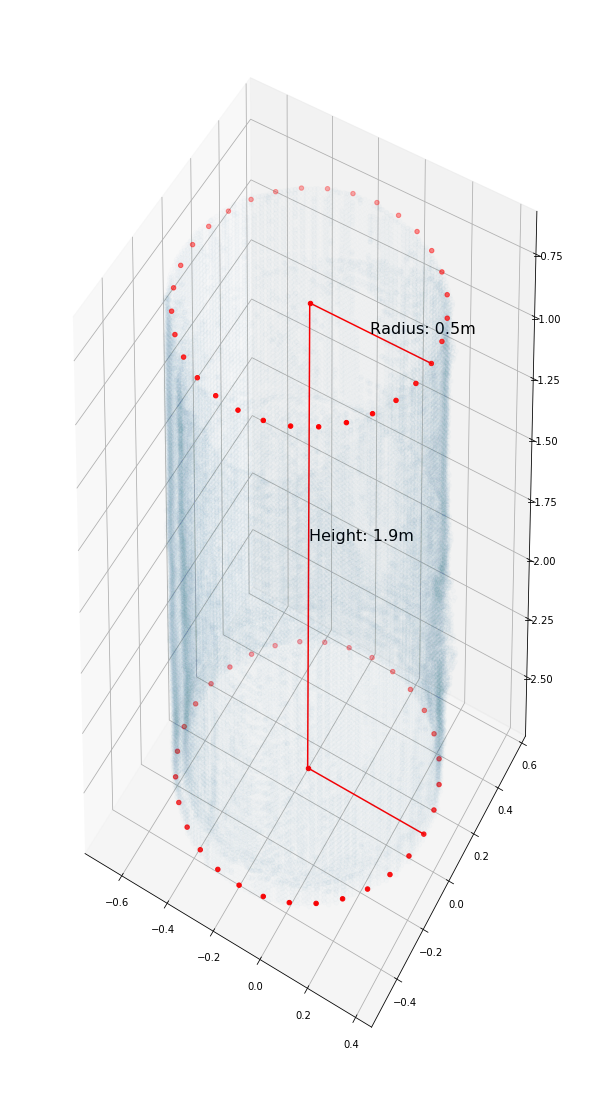

In [3]:
with open("cylinder5.json","r") as file:
    cs = CloudSchematic(json.load(file))
cs.generate()

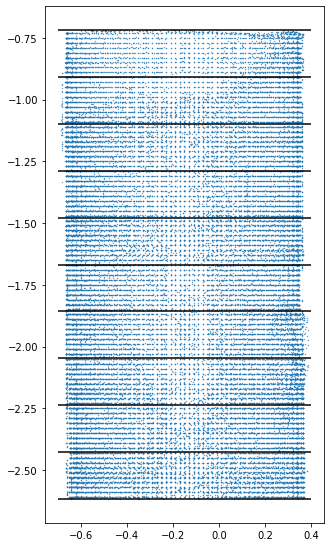

In [4]:
plt.figure(figsize=(5, 5*cs.ratio))
plt.scatter(x=np.array(cs.vertices)[:, 0], y=np.array(cs.vertices)[:, 2], s=.1)
for z_bounds in cs.z_bounds_low:
    plt.hlines(z_bounds, -.7, .4)
plt.hlines(cs.z_bounds_high[-1], -.7, .4)

In [5]:
cs.ratio

1.9

In [562]:
type(np.array([[0,0],[0,0]]))

numpy.ndarray

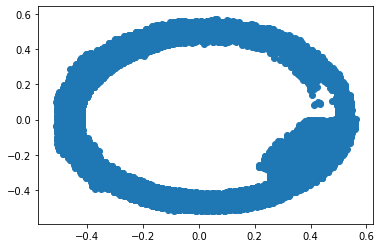

In [6]:
import json
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

with open("cylinder.json", "r") as file:
    data = json.load(file)
    
df = pd.DataFrame(data, columns=["x","y","z"])

view_dct = {
    "front": ["y", "z"],
    "side": ["x", "z"],
    "top": ["x", "y"]
}

def project(view="top"):
    plt.scatter(
        data=df,
        x=view_dct[view][0], 
        y=view_dct[view][1])
    
project("top")

In [7]:
with open("/home/becode/Projects/square1.json", "r") as file:
    square = pd.DataFrame(json.load(file), columns=["x","y","z"])

In [8]:
with open("cylinder.json", "r") as file:
    data = json.load(file)

In [9]:
df = pd.DataFrame(data, columns=["x","y","z"])
df.sort_values("z", inplace=True)

In [10]:
view_dct = {
    "front": ["y", "z"],
    "side": ["x", "z"],
    "top": ["x", "y"]
}

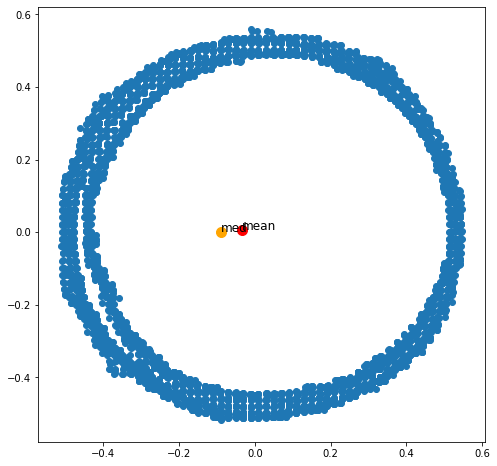

In [40]:
def project(view="top", bounds=(0,100)):
    slc = slice(len(df)//100*bounds[0], len(df)//100*bounds[1])
    plt.figure(figsize=(8,8))
    plt.scatter(data=df.iloc[slc], x=view_dct[view][0], y=view_dct[view][1])
    mean_a, mean_b = df.iloc[slc]["x"].mean(), df.iloc[slc]["y"].mean()  
    plt.scatter(mean_a, mean_b, c="r", s=100)
    plt.text(mean_a, mean_b, "mean", fontsize=12)  
    medi_a, medi_b = df.iloc[slc]["x"].median(), df.iloc[slc]["y"].median()
    plt.scatter(medi_a, medi_b, c="orange", s=100)
    plt.text(medi_a, medi_b, "med", fontsize=12)

project("top", (0,10))

In [25]:
def num_points_in_slice(bounds=(0,100)):
    slc = slice(len(df)//100*bounds[0], len(df)//100*bounds[1])
    return df.iloc[slc]
for i in range(0,100,10):
    print(num_points_in_slice((i, i+10)))

              x         y         z
43788 -0.459600 -0.143403 -0.775558
12886  0.315431 -0.365514 -0.775424
31108 -0.237674  0.390535 -0.775418
24090 -0.036721 -0.447100 -0.775375
20703  0.097633  0.491325 -0.774882
...         ...       ...       ...
8188   0.403413 -0.351427 -0.621250
47955 -0.502077  0.021089 -0.621236
28830 -0.170931  0.443642 -0.621232
14959  0.269673  0.443382 -0.621218
27758 -0.150995 -0.477677 -0.621209

[4810 rows x 3 columns]
              x         y         z
14353  0.282067  0.494127 -0.621206
43559 -0.443363 -0.233431 -0.621205
33397 -0.289720 -0.358947 -0.621201
18925  0.149508  0.486807 -0.621186
21870  0.049400  0.499337 -0.621175
...         ...       ...       ...
47179 -0.492522 -0.018520 -0.480724
46370 -0.473241  0.102018 -0.480723
13649  0.290638 -0.401918 -0.480720
6125   0.442281 -0.292907 -0.480716
47534 -0.490525  0.081285 -0.480715

[4810 rows x 3 columns]
              x         y         z
29180 -0.186789 -0.470581 -0.480715
4937   0.46047

In [26]:
height = df["z"].max() - df["z"].min()
tenth = height/10

In [27]:
for i in range(1, 11):
    print(i)

1
2
3
4
5
6
7
8
9
10


In [28]:
heights = [df["z"].min() + tenth*i for i in range(1, 10)]

In [29]:
dct = {
    i: lambda x: df["z"].min() + (tenth*i) < x < df["z"].min() + (tenth*i+1)
    for i in range(10)
}

In [30]:
df[df["z"].apply(dct[0])]

,x,y,z
12596,0.320411,0.451676,0.645718
19910,0.104143,-0.468826,0.646066
8850,0.418942,0.309645,0.646640
38959,-0.380801,-0.190549,0.646666
2809,0.519120,0.015133,0.647367
...,...,...,...
22099,0.047111,0.552227,0.803014
107,0.540418,-0.053948,0.803102
21271,0.067023,0.438533,0.803209
24226,-0.026436,0.433026,0.803221


In [31]:
min_val = df["z"].min()
z_bounds_low = [min_val +tenth*i for i in range(10)]
z_bounds_high = [min_val +tenth *(i+1) for i in range(10)]

In [32]:
vert_counts = [
    len(df[df["z"].apply(lambda x: z_bounds_low[i] < x < z_bounds_high[i])])
    for i in range(1, 9)
]

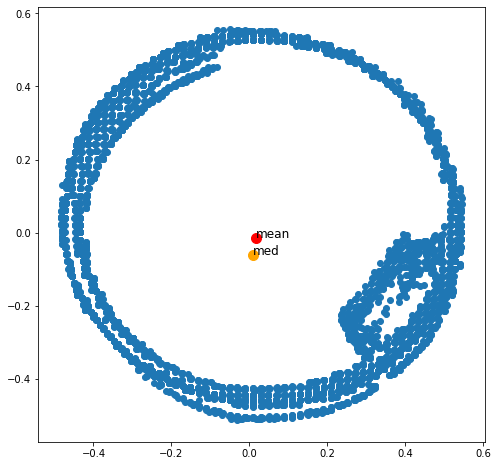

In [67]:
optimal_slice_idx = np.argmin(vert_counts) + 1
project("top", bounds=(optimal_slice_idx*10, (optimal_slice_idx+1)*10))

In [34]:
class CloudPrimitive:
    def __init__(self, points:[float]):
        

SyntaxError: unexpected EOF while parsing (<ipython-input-34-5163c0cf8acd>, line 3)

In [46]:
with open("cylinder.json", "r") as file:
    data = json.load(file)

In [64]:
min_val = df["z"].min()
tenth = cs.height /10
z_bounds_low = [min_val +tenth*i for i in range(10)]
z_bounds_high = [min_val +tenth *(i+1) for i in range(10)]

vert_counts = [
    len(df[df["z"].apply(lambda x: z_bounds_low[i] < x < z_bounds_high[i])])
    for i in range(1, 9)
]

optimal_slice_idx = np.argmin(vert_counts) -3
bounds=(optimal_slice_idx*10, (optimal_slice_idx+1)*10)


slc = slice(len(df)//100*bounds[0], len(df)//100*bounds[1])
data = df.iloc[slc].drop(columns="z")

mean_x, mean_y = df.iloc[slc]["x"].mean(), df.iloc[slc]["y"].mean()

data["distance"] = data.apply(lambda a: 
    ((mean_x - a["x"])**2 + (mean_y - a["y"])**2)**.5, axis=1
)

diameter = round(data["distance"].mean(), 2) *2

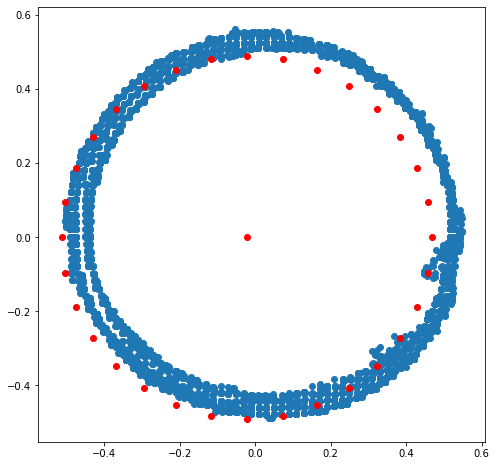

In [65]:
plt.figure(figsize=(8,8))

plt.scatter(data=data, x="x", y="y")

plt.scatter(mean_x, mean_y, c="r")

n_points = 32
radius = diameter /2
verts = []
delta = 2 * math.pi / n_points 
theta = 0.0
for i in range(n_points):
    theta += delta
    verts.append((mean_x + radius * math.cos(theta), mean_y + radius * math.sin(theta)))

plt.scatter(*list(zip(*verts)), c="r")


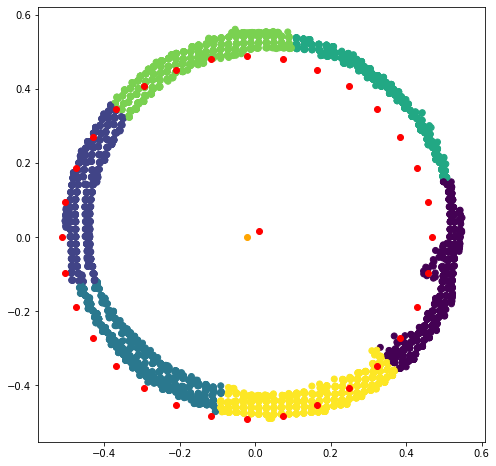

In [66]:
plt.figure(figsize=(8,8))

kmeans = KMeans(n_clusters=6).fit(data[["x","y"]])
data["cluster"] = kmeans.predict(data[["x","y"]])
centers = kmeans.cluster_centers_

center_x = sum(list(zip(*centers))[0]) /len(centers)
center_y = sum(list(zip(*centers))[1]) /len(centers)

plt.scatter(data=data, x="x", y="y", c="cluster")
plt.scatter(center_x, center_y, c="r")

plt.scatter(mean_x, mean_y, c="orange")
plt.scatter(*list(zip(*verts)), c="r")
plt.show()

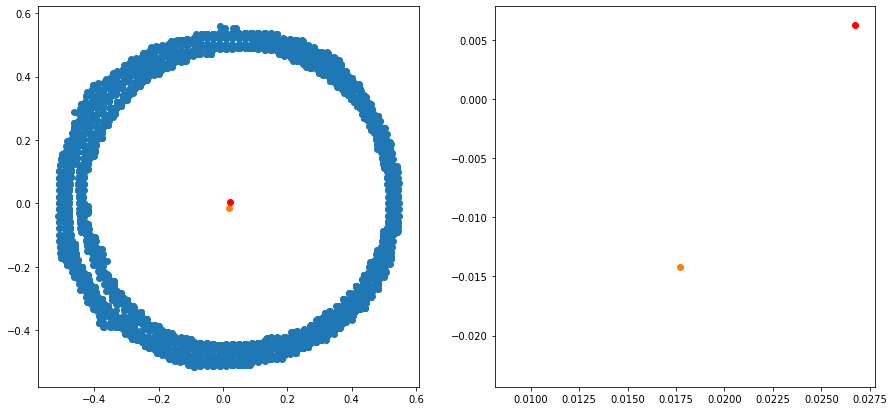

In [34]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

sub_df = df[df["z"].apply(lambda x: z_bounds_low[0] < x < z_bounds_high[0])]
ax[0].scatter(data=sub_df, x="x", y="y")
ax[0].scatter(data["x"].mean(), data["y"].mean())
centroids = KMeans(n_clusters=6).fit(data[["x","y"]]).cluster_centers_
fit_x, fit_y = centroids[:,0].mean(), centroids[:,1].mean()
ax[0].scatter(fit_x, fit_y, c="r")

sub_df = df[df["z"].apply(lambda x: z_bounds_low[-1] < x < z_bounds_high[-1])]
ax[1].scatter(data=sub_df, x="x", y="y")
ax[1].scatter(data["x"].mean(), data["y"].mean())
centroids = KMeans(n_clusters=6).fit(data[["x","y"]]).cluster_centers_
fit_x, fit_y = centroids[:,0].mean(), centroids[:,1].mean()
ax[1].scatter(fit_x, fit_y, c="r")

In [534]:
def calc_circle_points(n_points=32, radius=1, origin=(0,0)):
    vertices = []
    delta = 2 * math.pi / n_points 
    theta = 0.0
    for i in range(n_points):
        theta += delta
        if len(origin)==2:
            vertices.append((
                origin[0] + radius * math.cos(theta),
                origin[1] + radius * math.sin(theta)))
        else:
            vertices.append((
                origin[0] + radius * math.cos(theta),
                origin[1] + radius * math.sin(theta),
                origin[2]))
            
    return np.array(vertices)

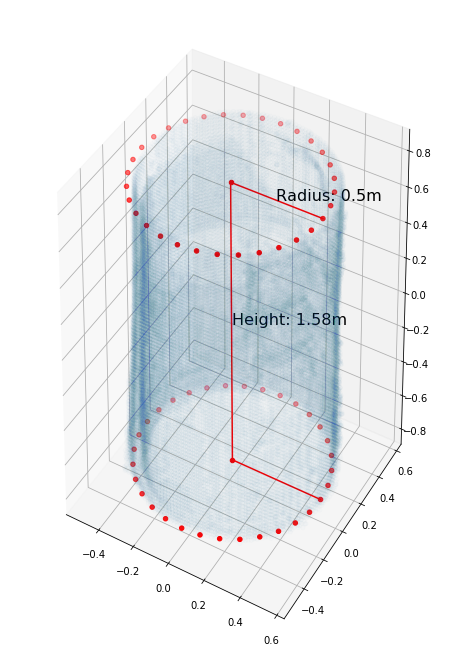

In [536]:
height = round(df["z"].max() - df["z"].min(), 2)

sub_df = df[df["z"].apply(lambda x: z_bounds_low[0] < x < z_bounds_high[0])]
centroids = KMeans(n_clusters=6).fit(data[["x","y"]]).cluster_centers_
fit_x, fit_y = centroids[:,0].mean(), centroids[:,1].mean()
center_point_bottom = (fit_x, fit_y, df["z"].min())

sub_df = df[df["z"].apply(lambda x: z_bounds_low[-1] < x < z_bounds_high[-1])]
centroids = KMeans(n_clusters=6).fit(data[["x","y"]]).cluster_centers_
fit_x, fit_y = centroids[:,0].mean(), centroids[:,1].mean()
center_point_top = (fit_x, fit_y, df["z"].max())

circle_points_bottom = calc_circle_points(radius=diameter/2, origin=center_point_bottom)
circle_points_top = calc_circle_points(radius=diameter/2, origin=center_point_top)

fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df["x"], df["y"], df["z"], alpha=.01)

ax.scatter(*center_point_bottom, c="r")
ax.scatter(*center_point_top, c="r")
ax.plot(*list(zip(center_point_bottom,center_point_top)),c="r")
middle = (np.array(center_point_bottom)+np.array(center_point_top))/2
ax.text(*middle, f"Height: {height}m", size=16)
ax.plot(*list(zip(center_point_bottom, circle_points_bottom[-1,:])),c="r")
ax.plot(*list(zip(center_point_top, circle_points_top[-1,:])),c="r")
middle = (np.array(center_point_top)+np.array(circle_points_top[-1,:]))/2
ax.text(*middle, f"Radius: {diameter/2}m", size=16)

ax.scatter(
    list(circle_points_bottom[:,0]),
    list(circle_points_bottom[:,1]),
    list(circle_points_bottom[:,2]), c="r")
ax.scatter(
    list(circle_points_top[:,0]),
    list(circle_points_top[:,1]),
    list(circle_points_top[:,2]), c="r")